In [ ]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(3)

----------------------------------------------
# nn Module


## make data

In [ ]:
x_train = 2 * torch.rand(100,1)
y_train = 4 * x_train + 6 + torch.randn(100,1)

x, y = Variable(x_train), Variable(y_train)

plt.scatter(x.data, y.data)
plt.show()

## Define Linear Model

[Pytorch Layer의 종류](https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/#nnmodule)

In [ ]:
model  = nn.Linear(1, 1, bias=True)
# model.weight, model.bias

## Define Cost Function 
Loss function은 모델이 추측한 결과(prediction)과 실제 정답(y)의 loss를 계산한다.
> nn.L1Loss, nn.MSELoss, nn.CrossEntropyLoss

In [ ]:
cost_func = nn.MSELoss()

## Define Optimizer 
torch.optim.Optimizer(params, defaults)

> **step()** : argument로 전달받은 parameter를 업데이트   
> **zero_grad()** : optimizer에 연결된 parameter들의 gradient를 0으로 만듦  
> **torch.optim.lr_scheduler** : epoch에 따라 learning rate를 조절

모델의 parameter별로 다른 기준(learning rate 등)을 적용시킬 수 있다. [참고](https://pytorch.org/docs/stable/optim.html#per-parameter-options)  

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


## Training w/ nn module

In [ ]:
def train(x, y, model, cost_func, optimizer, num_epoch=1000) :
    plt.ion()

    for step in range(num_epoch):
        prediction = model(x)
        cost = cost_func(prediction, y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if step % 50 == 0:
            print('step : %.f, cost=%.4f' % (step, cost.data))
#             print('step : %.f, cost=%.4f, w=%.4f, b=%.4f' % (step, cost.data,model.weight.data[0][0],model.bias.data))
#             plt.cla()
#             plt.scatter(x.data.numpy(), y.data.numpy())
#             plt.plot(x.data.numpy(), prediction.data.numpy(), 'b--')
#             plt.title('cost=%.4f, w=%.4f, b=%.4f' % (cost.data,model.weight.data[0][0],model.bias.data))
#             plt.show()

    plt.ioff()

In [ ]:
train(x_train, y_train, model, cost_func, optimizer)

## Testing model

In [ ]:
x_test = Variable(torch.Tensor([[7]]))
y_test = model(x_test)

print('input : %.4f, output:%.4f, expectation:%.4f' % (x_test.data[0][0], y_test.data[0][0], x_test.data[0][0]*4+6))

-----------
###  Has "nn.MSELoss()"  Convex Cost Space?

In [ ]:
W_val, cost_val = [], []

for i in range(-220, 300):
    W = i * 0.1
    model.weight.data.fill_(W)
    cost =  cost_func(model(x),y)
#     print(model.weight.data)
    
    W_val.append(W)
    cost_val.append(cost.data)

plt.plot(W_val, cost_val, 'ro')
plt.show()

--------------------------------------------------------------
# Multivariate Linear model (다중 선형 회귀)

단순 선형 회귀와 다른 점은, 독립 변수 x의 개수가 1개가 아닌 2개 이상이다.  

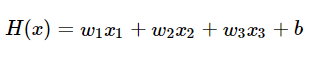


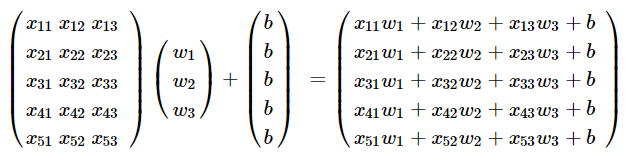

----------------------------
# DataLoader
파이토치에서는 데이터를 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 데이터셋(Dataset)과 데이터로더(DataLoader)를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다.

In [ ]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

텐서를 입력받아 Dataset의 형태로 변환해주는 TensorDataset을 사용해보겠습니다  
[torch.utils.data.Dataset](https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset)

In [ ]:
#3개의 퀴즈 점수로부터 최종 점수를 예측하는 모델  
xy = np.loadtxt('./data/data-01-test-score.csv', delimiter=',', dtype=np.float32)
x_data = xy[1:, :-1]
y_data = xy[1:, [-1]]
x, y = Variable(torch.from_numpy(x_data)), Variable(torch.from_numpy(y_data))

In [ ]:
dataset = TensorDataset(x, y)
# dataset.__len__()

shuffle=True를 선택하면 Epoch마다 데이터셋을 섞어서 데이터가 학습되는 순서를 바꿉니다.

In [ ]:
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

## Training

In [ ]:
model = nn.Linear(3,1)
cost_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

In [ ]:
num_epochs = 2000
for epoch in range(num_epochs):
    for batch_idx, samples in enumerate(dataloader):

        x_train, y_train = samples
        
        prediction = model(x_train)
        cost = cost_func(prediction, y_train)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
            epoch, num_epochs, batch_idx+1, len(dataloader),
            cost.item()
            ))

## test 

In [ ]:
print("Model score : ",model(Variable(torch.Tensor([[73,80,75]]))).data.numpy())
print("Real score : 73,80,75,152")

----------------------------------------
# 모델 save & load
PyTorch에서 torch.nn.Module 모델의 학습 가능한 매개변수(예. 가중치와 편향)들은 모델의 매개변수에 포함되어 있습니다(model.parameters()로 접근합니다). state_dict 는 각 계층을 매개변수 텐서로 매핑되는 Python 사전(dict) 객체입니다. 이는 쉽게 저장하거나 갱신하거나 바꾸거나 되살릴 수 있으며, PyTorch 모델과 Optimizer에 모듈성을 제공합니다.

In [ ]:
model.parameters()

In [ ]:
model.state_dict()

### state_dict save & load
추론을 위해 모델을 저장할 때는 학습된 모델의 학습된 매개변수만 저장하면 됩니다. torch.save() 를 사용하여 모델의 state_dict 를 저장합니다.  

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
model = TheModelClass(*args, **args)
model.load_state_dict(torch.load(PATH))
model.eval()

### 추론 / 학습 재개를 위해 일반 체크포인트(checkpoint) 저장하기 & 불러오기

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)

In [ ]:
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()